## Image Registration Tutorial - Multi Modal Registration

We start by setting up the Python environment and pre-define some useful functions for warping and displaying images.

In [1]:
import sys
sys.path.append('../src')
import imagedisplay

import SimpleITK as sitk
import numpy as np
import math as mt

import matplotlib.pyplot as plt
%matplotlib inline
from imagedisplay import myshow
from IPython.display import display, clear_output

# Define the warping function
def warpmyimage(reference,img_source,transformation):
    
    stats = sitk.StatisticsImageFilter()
    stats.Execute( img_source )
    minval = stats.GetMinimum()
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(minval)
    resampler.SetTransform(transformation)
    moving = resampler.Execute(img_source)
    return moving

def cmyshow(img1,img2,*args, **kw):
    simg1 = sitk.Cast(sitk.RescaleIntensity(img1), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(img2), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1/2.+simg2/2.)
    myshow(cimg,*args, **kw)

### CT-MRI registration

Here, we are running a full multi modal CT-MRI registration. The original images are already aligned, so we apply a random transformation to the moving image initially. The registration method is then trying to recover this transformation.

TASK: a) Modify the code below such that the registration 'works', b) Try out differernt initial transformation parameters

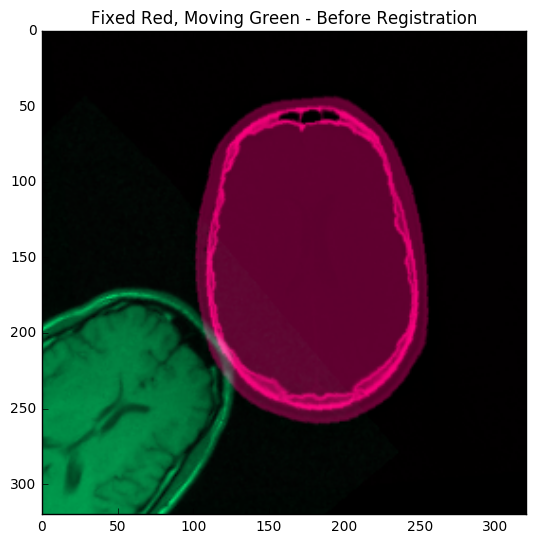

In [16]:
# Multi Modal Image Registration
fixedInputFilename = "../data/ct.nii.gz"
movingInputFilename = "../data/mr.nii.gz"
fixed = sitk.ReadImage(fixedInputFilename)
moving = sitk.ReadImage(movingInputFilename)

# Define a transformation and warp the moving image (this time transformation is in 3D)
# Resample the moving image based on this transformation

# CHANGE CODE HERE: Try different initial transformation parameters
angleZ = -3.14*50/180; tx = -45.00;  ty = 0.00;

t_input=sitk.Transform(fixed.GetDimension(), sitk.sitkEuler)
t_input.SetParameters([0,0,angleZ,tx,ty,0])
moving = warpmyimage(fixed,moving,t_input)

cmyshow(fixed,moving, title="Fixed Red, Moving Green - Before Registration", dpi = 50)

0 = -0.0740805110599 : (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
100 = -0.159194621387 : (-1.64267570308037e-10, 6.820431745776227e-11, -0.16516670824414845, 23.4681684840974, -3.13224559432589, -9.790171894282758e-10)
-------
Optimizer stop condition: AmoebaOptimizerv4: Both parameters convergence tolerance (0.0001) and function convergence tolerance (0.001) have been met in 188 iterations.
 Iteration: 196
 Metric value: -0.159220666609
0 = -0.148580124907 : (-1.6423967844994283e-10, 6.821611283606306e-11, -0.16512150718625526, 23.464199916402343, -3.131033727144346, -9.789817098762416e-10)
100 = -0.151670273066 : (2.4398708290503243e-10, 2.3985594003466057e-10, -0.1618810730632162, 13.347208889882262, -12.874348568155654, -1.5747289476612093e-10)
200 = -0.151708734894 : (2.517850733416855e-10, 2.3683131111099217e-10, -0.16183650693293258, 13.250188048020144, -12.917209556916779, -1.536553012867134e-10)
-------
Optimizer stop condition: AmoebaOptimizerv4: Both parameters convergence tolerance (0

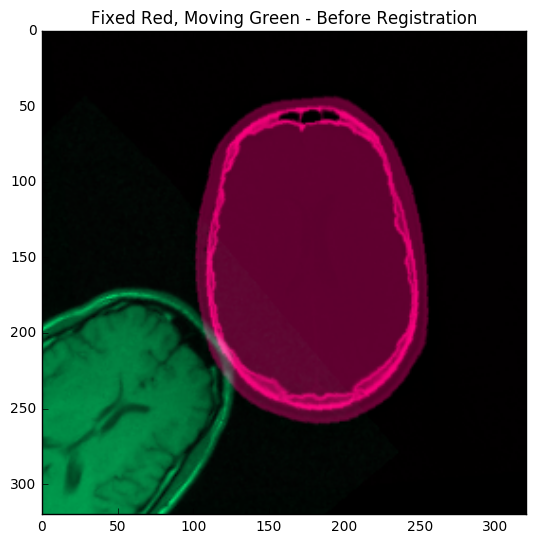

In [17]:
global t_output
t_output = sitk.Transform(fixed.GetDimension(), sitk.sitkEuler)

# Multi-scale registration 
levels = [8,4]
for level in levels:

    fixed_s = sitk.DiscreteGaussian(fixed, 2.0 * level )
    moving_s = sitk.DiscreteGaussian(moving, 2.0 * level )
    
    fixed_s = sitk.Shrink(fixed_s, [1,1] * level )
    moving_s = sitk.Shrink(moving_s, [1,1] * level )
        
    # Create the registration object and set its properties
    R = sitk.ImageRegistrationMethod()
    R.SetOptimizerAsAmoeba(simplexDelta=3, numberOfIterations=10000, parametersConvergenceTolerance=0.0001,functionConvergenceTolerance=0.001); 
    R.SetOptimizerScales([1e10,1e10,100,1,1,1e10])
    R.SetInterpolator(sitk.sitkLinear)
    R.SetInitialTransform(t_output)
    R.SetNumberOfThreads(8)
    
    # Define the (dis)similarity measure, sum of squared differences
    R.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    
    # To observe the cost function over iterations
    def command_iteration(method) :
        if ((method.GetOptimizerIteration() % 100) == 0):
            print("{0} = {1} : {2}".format(method.GetOptimizerIteration(),
                                           method.GetMetricValue(),
                                           method.GetOptimizerPosition()));
            sys.stdout.flush();   
    def command_end(R):
        print("-------")
        print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
        print(" Iteration: {0}".format(R.GetOptimizerIteration()))
        print(" Metric value: {0}".format(R.GetMetricValue()))
        sys.stdout.flush();

    R.RemoveAllCommands()
    R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )
    R.AddCommand( sitk.sitkEndEvent, lambda: command_end(R) )

    # Run the registration and warp moving image
    t_output = R.Execute(fixed_s,moving_s)

warped_image = warpmyimage(fixed,moving,t_output)
cmyshow(fixed,moving, title="Fixed Red, Moving Green - Before Registration", dpi = 50)
cmyshow(fixed,warped_image, title="Fixed Red, Moving Green - After Registration", dpi = 50)